# 協調フィルタリングモジュール collab と推奨システム D-Recommend

> 協調フィルタリングモジュール collab と推奨システム D-Recommend


In [ ]:
#| default_exp collab

In [ ]:
#| include: false
from nbdev.showdoc import *
%reload_ext autoreload
%autoreload 2

In [ ]:
#| export
from fastai import *
from fastai.tabular import *
from fastai.tabular.all import *
from fastai.collab import *
from faker import Faker
import plotly.graph_objs as go
import plotly.express as px
import plotly
folder ="./data/collab/"

In [ ]:
#| include: false
from IPython.display import Image, YouTubeVideo

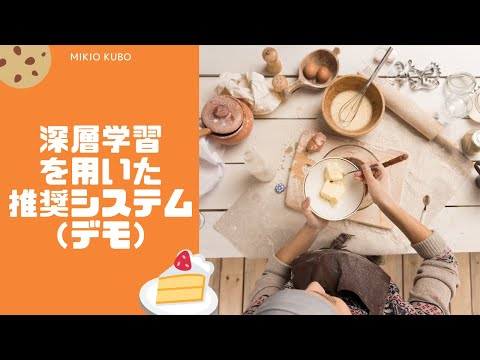

In [ ]:
#| echo: false
YouTubeVideo("1LMA8PGbS4Y")

## 映画（rating)データの読み込み

Movie Lensのデータセット https://grouplens.org/datasets/movielens/ を用いる．

まずは映画のレイティング(rating）データを読み込む．

In [ ]:
path = untar_data(URLs.ML_100k)
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


映画のデータも読み込む． movie列がratingデータと共有であり， ratingデータにマージすることによって映画のタイトル列を追加する．

In [ ]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.set_index("movie",inplace=True)

In [ ]:
movies.reset_index(inplace=True)
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


ユーザーデータを準備する． Fakerパッケージを使って架空のユーザーを生成し，ratingデータに追加する．

In [ ]:
user = list(set(ratings.user))
movie = list(set(ratings.movie))
print(len(user),len(movie))
fake = Faker(['en_US', 'ja_JP','zh_CN','ko_KR'])
Faker.seed(1)
name_dic ={}
for i in user:
    name_dic[i] = fake.name() 
#name_dic

943 1682


In [ ]:
#名前の追加
user = list(set(ratings.user))
movie = list(set(ratings.movie))
print(len(user),len(movie))
fake = Faker(['en_US', 'ja_JP','zh_CN','ko_KR'])
Faker.seed(1)
name_dic ={}
for i in user:
    name_dic[i] = fake.name() 
name =[]
for i in ratings.user:
    name.append( name_dic[i])
ratings["name"] = name 

943 1682


In [ ]:
ratings.columns =["user","movie","rating","title","name"]
ratings_df = ratings.reindex(columns= ["user","name", "movie","title","rating"])
#ratings_df.to_csv(folder+"rating.csv", index=False)
ratings_df

,user,name,movie,title,rating
0,196,윤정식,242,Kolya (1996),3
1,63,商畅,242,Kolya (1996),3
2,226,吴波,242,Kolya (1996),5
3,154,Edward Wright,242,Kolya (1996),3
4,306,Scott Lawrence,242,Kolya (1996),5
...,...,...,...,...,...
99995,840,Jesse Torres,1674,Mamma Roma (1962),4
99996,655,井上 拓真,1640,"Eighth Day, The (1996)",3
99997,655,井上 拓真,1637,Girls Town (1996),3
99998,655,井上 拓真,1630,"Silence of the Palace, The (Saimt el Qusur) (1994)",3


In [ ]:
#| include: false
#movies.to_csv(folder+"movies.csv",index=False)

In [ ]:
users = pd.DataFrame( {"id": user, "name": [name_dic[i] for i in user]} )
#users.to_csv(folder+"users.csv",index=False)

## 分析

上で生成したratingデータ（ユーザー名と映画タイトル追加済み）を読み込む．


In [ ]:
ratings_df = pd.read_csv(folder+"rating.csv")
ratings_df.head()

,user,name,movie,title,rating
0,196,张颖,242,Kolya (1996),3
1,63,우정자,242,Kolya (1996),3
2,226,James Anderson,242,Kolya (1996),5
3,154,李建国,242,Kolya (1996),3
4,306,宋峰,242,Kolya (1996),5


映画の平均レイティングを計算する．

In [ ]:
movies_df = pd.read_csv(folder+"movies.csv")
ave_rate = pd.pivot_table(ratings_df, index="movie", values="rating", aggfunc= "mean")
movies_df["average rating"] = list(ave_rate.rating)
movies_df.head()

,movie,title,average rating
0,1,Toy Story (1995),3.878319
1,2,GoldenEye (1995),3.206107
2,3,Four Rooms (1995),3.033333
3,4,Get Shorty (1995),3.550239
4,5,Copycat (1995),3.302326


ユーザーごとの平均レイティングを計算する．

In [ ]:
users_df = pd.read_csv(folder+"users.csv")
ave_user = pd.pivot_table(ratings_df, index="user", values="rating", aggfunc= "mean")
users_df["average rating"] = list(ave_user.rating)
users_df.head(11)

,id,name,average rating
0,1,Ryan Gallagher,3.610294
1,2,박영길,3.709677
2,3,後藤 あすか,2.796296
3,4,Russell Reynolds,4.333333
4,5,佐藤 七夏,2.874286
5,6,伊藤 陽子,3.635071
6,7,김경자,3.965261
7,8,Teresa James,3.796610
8,9,이경수,4.272727
9,10,徐娟,4.206522


## 学習器の生成と訓練を行う関数 colab_learn

In [ ]:
#| export
def colab_learn(ratings_df):
    ratings = ratings_df[ ["user","movie","rating"] ]
    dls = CollabDataLoaders.from_df(ratings, valid_pct=0.1, bs=64)
    learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5), loss_func=MSELossFlat())
    learn.fit_one_cycle(5, 5e-3, wd=0.1)
    return learn

### colab_learnの使用例

In [ ]:
learn = colab_learn(ratings_df)

epoch,train_loss,valid_loss,time
0,0.900057,0.917428,00:06
1,0.865561,0.850833,00:06
2,0.735190,0.805221,00:06
3,0.612931,0.789337,00:06
4,0.499000,0.788837,00:06


In [ ]:
preds0, target0, decoded0, loss0 = learn.get_preds(ds_idx=0, with_decoded=True, with_loss=True)
loss0

TensorBase([0.1374, 0.1485, 0.1860,  ..., 1.0949, 0.2373, 1.2814])

#hide
レイティングの上位 100 の映画を抽出しておく．

In [ ]:
#| include: false
g = ratings_df.groupby('movie')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:]
top100 = top_movies[:1000]

## 予測を行う関数 colab_predict

In [ ]:
#| export
def colab_predict(learn, movies_df, user_id):
    n = len(movies_df)
    df = pd.DataFrame({"user":[user_id for i in range(n)], "movie": movies_df.movie, "rating": [0 for i in range(n)]}) #prepare data frame
    dl = learn.dls.test_dl(df) # make a <test> data loader 
    y_pred = learn.get_preds(dl = dl)  #predict 
    recommend_df = pd.DataFrame({"movie":movies_df.movie, "recommend movie": movies_df.title, "rating": y_pred[0]} ).sort_values(by="rating",ascending=False)
    return recommend_df

### colab_predict関数の使用例

user_idが10のユーザーに対する推奨映画

In [ ]:
recommend_df = colab_predict(learn, movies_df, user_id=10)

In [ ]:
recommend_df.head()

,movie,recommend movie,rating
317,318,Schindler's List (1993),4.820768
126,127,"Godfather, The (1972)",4.793285
356,357,One Flew Over the Cuckoo's Nest (1975),4.766077
131,132,"Wizard of Oz, The (1939)",4.755078
133,134,Citizen Kane (1941),4.741590


このユーザーのレイティングを確認する．

In [ ]:
ratings_df[ ratings_df.user==10 ].head()

,user,name,movie,title,rating
177,10,徐娟,302,L.A. Confidential (1997),4
676,10,徐娟,474,Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963),4
2276,10,徐娟,40,"To Wong Foo, Thanks for Everything! Julie Newmar (1995)",4
2559,10,徐娟,274,Sabrina (1995),4
2798,10,徐娟,486,Sabrina (1954),4


## 可視化

### アイテム（映画）を2次元に可視化する関数 show_item_map

In [ ]:
#| export
def show_item_map(learn, movies_df):
    movie_w = learn.model.weight(movies_df.movie, is_item=True) #weight matrix
    movie_pca = movie_w.pca(3) #PCA
    fac0,fac1,fac2 = movie_pca.t() #top 3 主成分
    movies_df["PCA1"] = fac0
    movies_df["PCA2"] = fac1
    movies_df["PCA3"] = fac2
    fig = px.scatter(movies_df, x="PCA1", y="PCA2", hover_name="title", text="title", size="average rating", size_max=10, opacity=0.8, color="average rating")
    return fig, movies_df 

### show_item_map関数の使用例

In [ ]:
# fig, movies = show_item_map(learn, movies_df)
# plotly.offline.plot(fig);
# movies.head()

,movie,title,average rating,PCA1,PCA2,PCA3
0,1,Toy Story (1995),3.878319,0.444091,0.520046,-0.033139
1,2,GoldenEye (1995),3.206107,-0.039345,0.377593,0.204351
2,3,Four Rooms (1995),3.033333,-0.270448,0.101434,0.574822
3,4,Get Shorty (1995),3.550239,0.457936,0.075438,0.199581
4,5,Copycat (1995),3.302326,-0.138418,0.573008,-0.084740


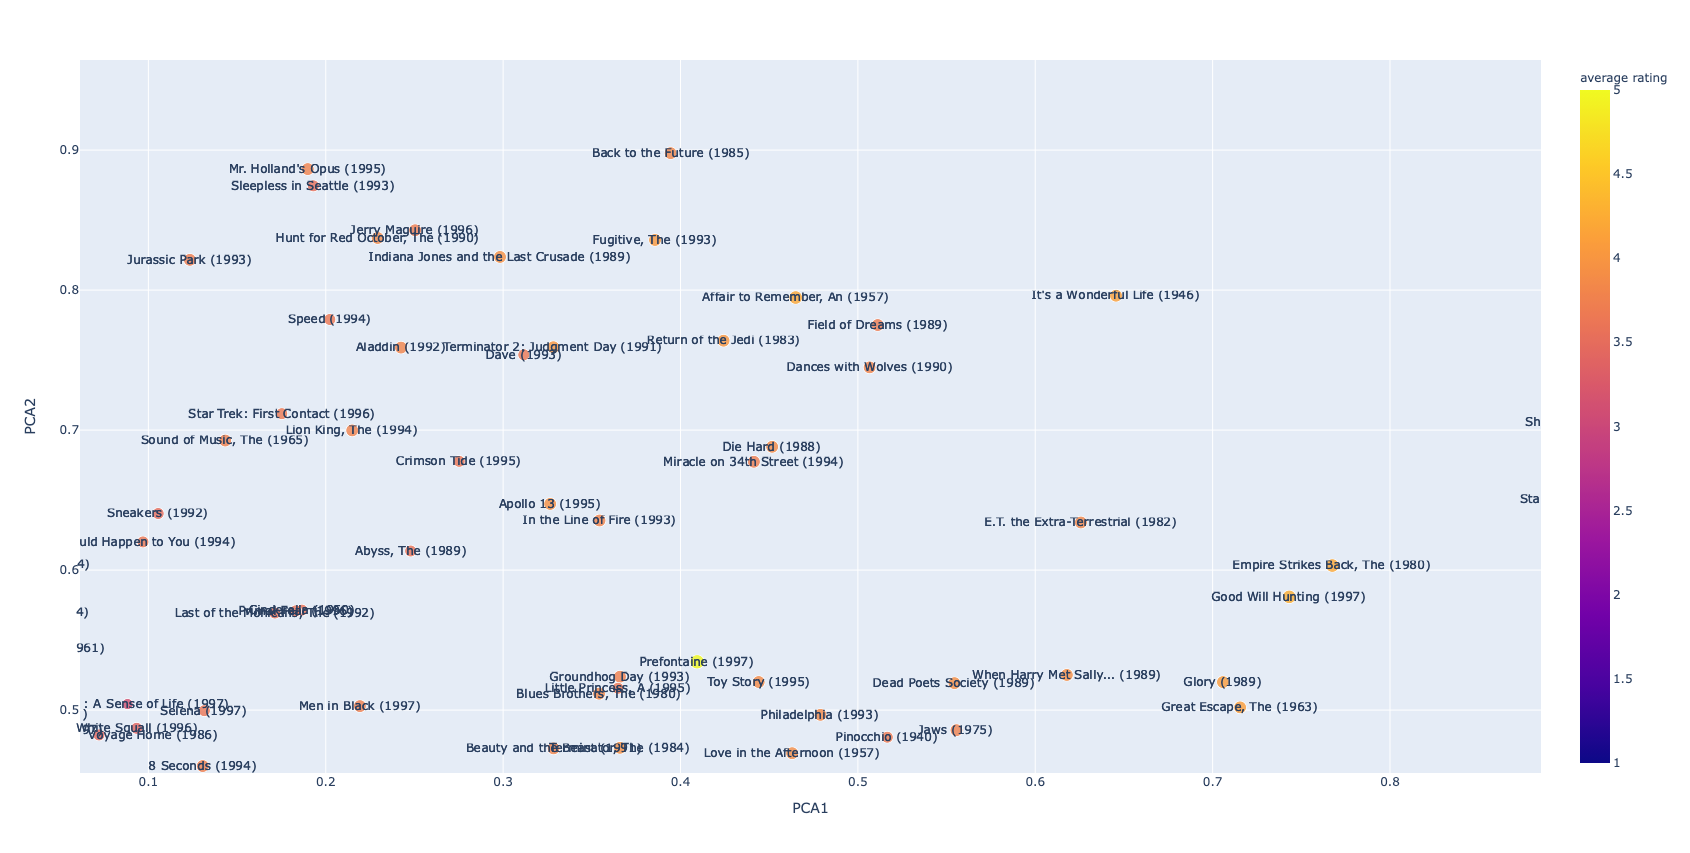

In [ ]:
#| echo: false
Image("../figure/recommend0.png", width=1000)

### ユーザーを2次元に可視化する関数 show_user_map

In [ ]:
#| export
def show_user_map(learn, users_df):
    user_w = learn.model.weight(users_df.id, is_item=False)
    user_pca = user_w.pca(3)
    fac0,fac1,fac2 = user_pca.t()
    users_df["PCA1"] = fac0
    users_df["PCA2"] = fac1
    users_df["PCA3"] = fac2
    fig = px.scatter(users_df, x="PCA1", y="PCA2",  text="name", size_max=1, opacity=0.8, color="average rating")
    return fig, users_df 

### show_user_map関数の使用例

In [ ]:
# fig, users = show_user_map(learn, users_df)
# plotly.offline.plot(fig);
# users.head()

,id,name,average rating,PCA1,PCA2,PCA3
0,1,Ryan Gallagher,3.610294,0.540301,-0.043214,-0.551639
1,2,박영길,3.709677,0.215085,-0.478103,-0.068856
2,3,後藤 あすか,2.796296,0.225072,0.370120,-0.026158
3,4,Russell Reynolds,4.333333,-0.085290,0.185153,-0.412719
4,5,佐藤 七夏,2.874286,0.451194,0.577116,-0.321961


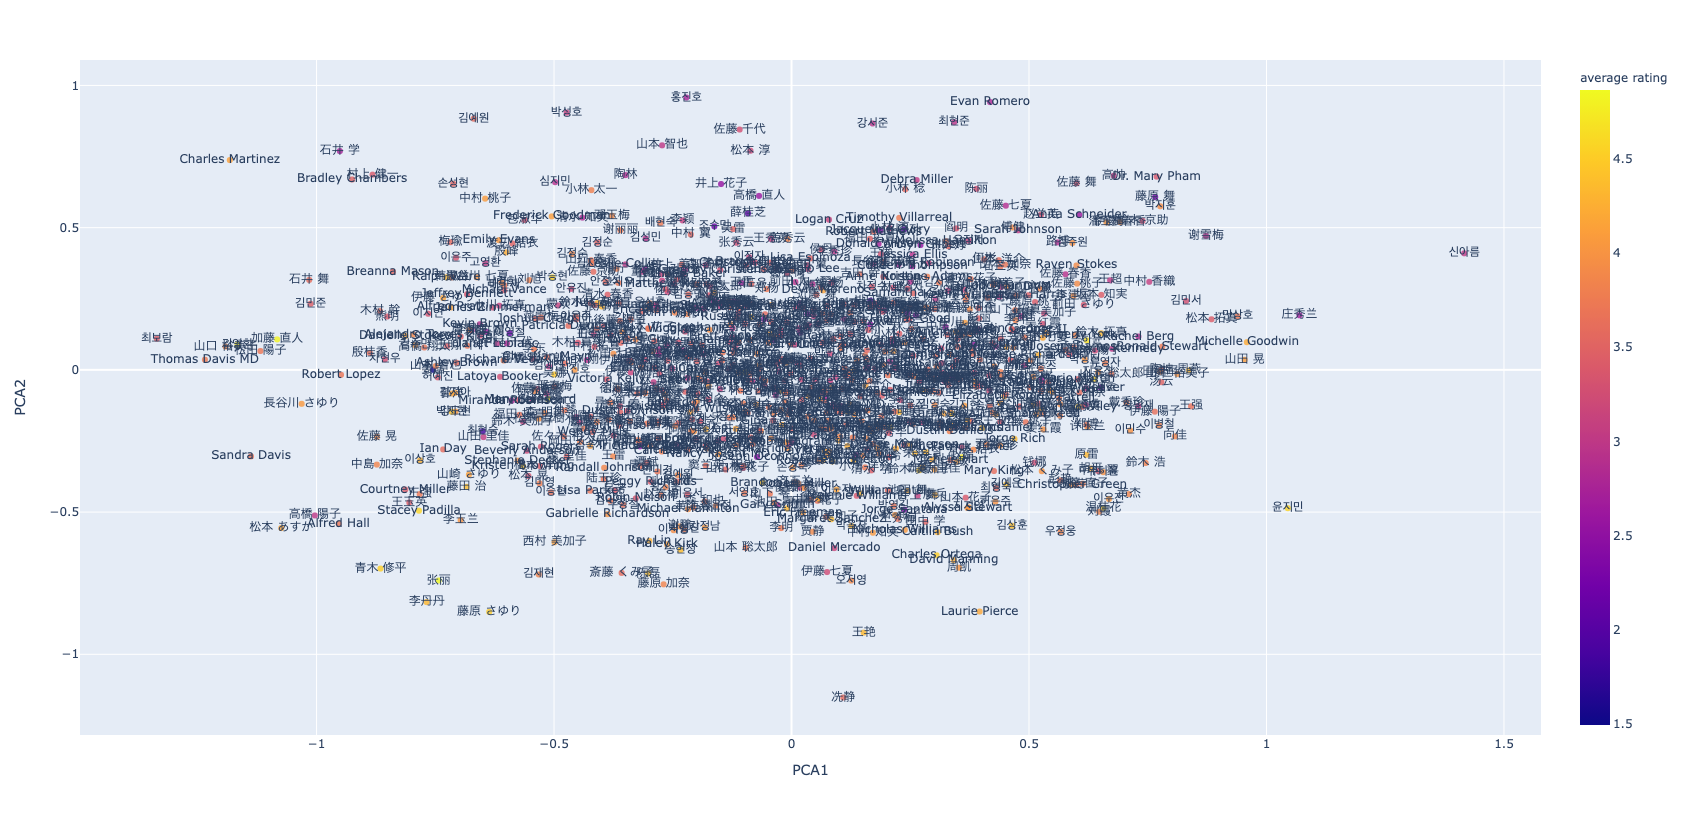

In [ ]:
#| echo: false
Image("../figure/recommend1.png", width=1000)

### ユーザーへの推奨アイテムを可視化する関数 show_recommend

In [ ]:
#| export
def show_recommend(learn, movies_df, recommend_df, best=100):
    movie_w = learn.model.weight(movies_df.movie, is_item=True) #weight matrix
    movie_pca = movie_w.pca(3) #PCA
    fac0,fac1,fac2 = movie_pca.t() #top 3 主成分
    movies_df["PCA1"] = fac0
    movies_df["PCA2"] = fac1
    movies_df["PCA3"] = fac2
    recommend_new = pd.merge(recommend_df, movies_df, on="movie")
    fig = px.scatter(recommend_new[:best], x="PCA1", y="PCA2", hover_name="title", text="title", size= "rating", opacity=0.8, color="rating")
    return fig

In [ ]:
# fig = show_recommend(learn, movies_df, recommend_df, best=100)
# plotly.offline.plot(fig);

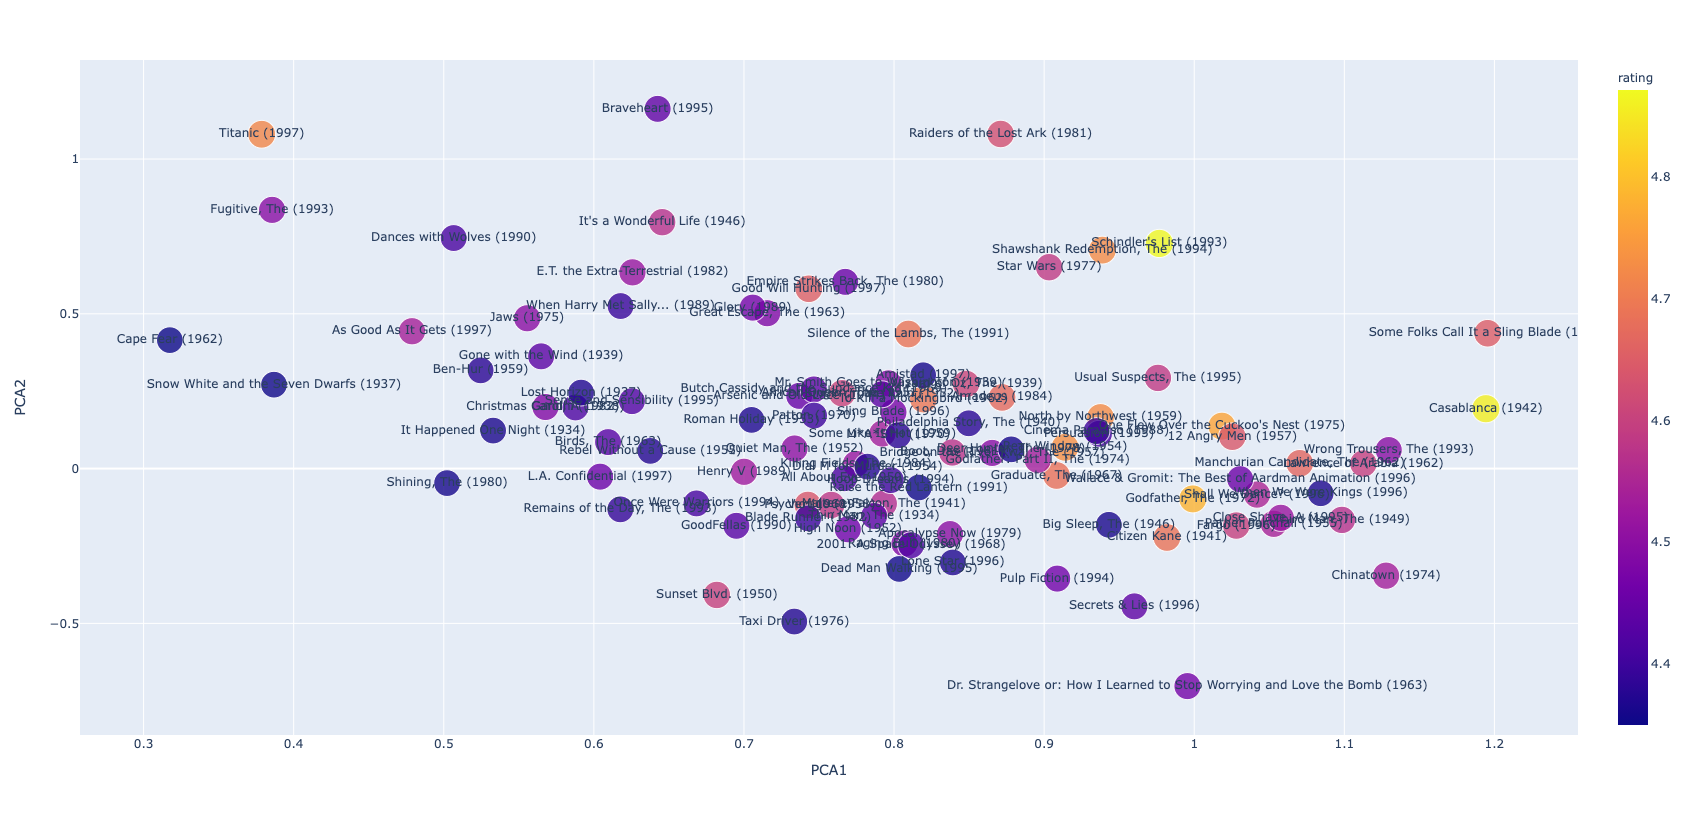

In [ ]:
#| echo: false
Image("../figure/recommend2.png", width=1000)

In [ ]:
#| include: false
#３次元の図
# fig = px.scatter_3d(movies, x="PCA1", y="PCA2", z="PCA3", hover_name="title", size_max=1, opacity=0.8, color="average rating")
# plotly.offline.plot(fig);

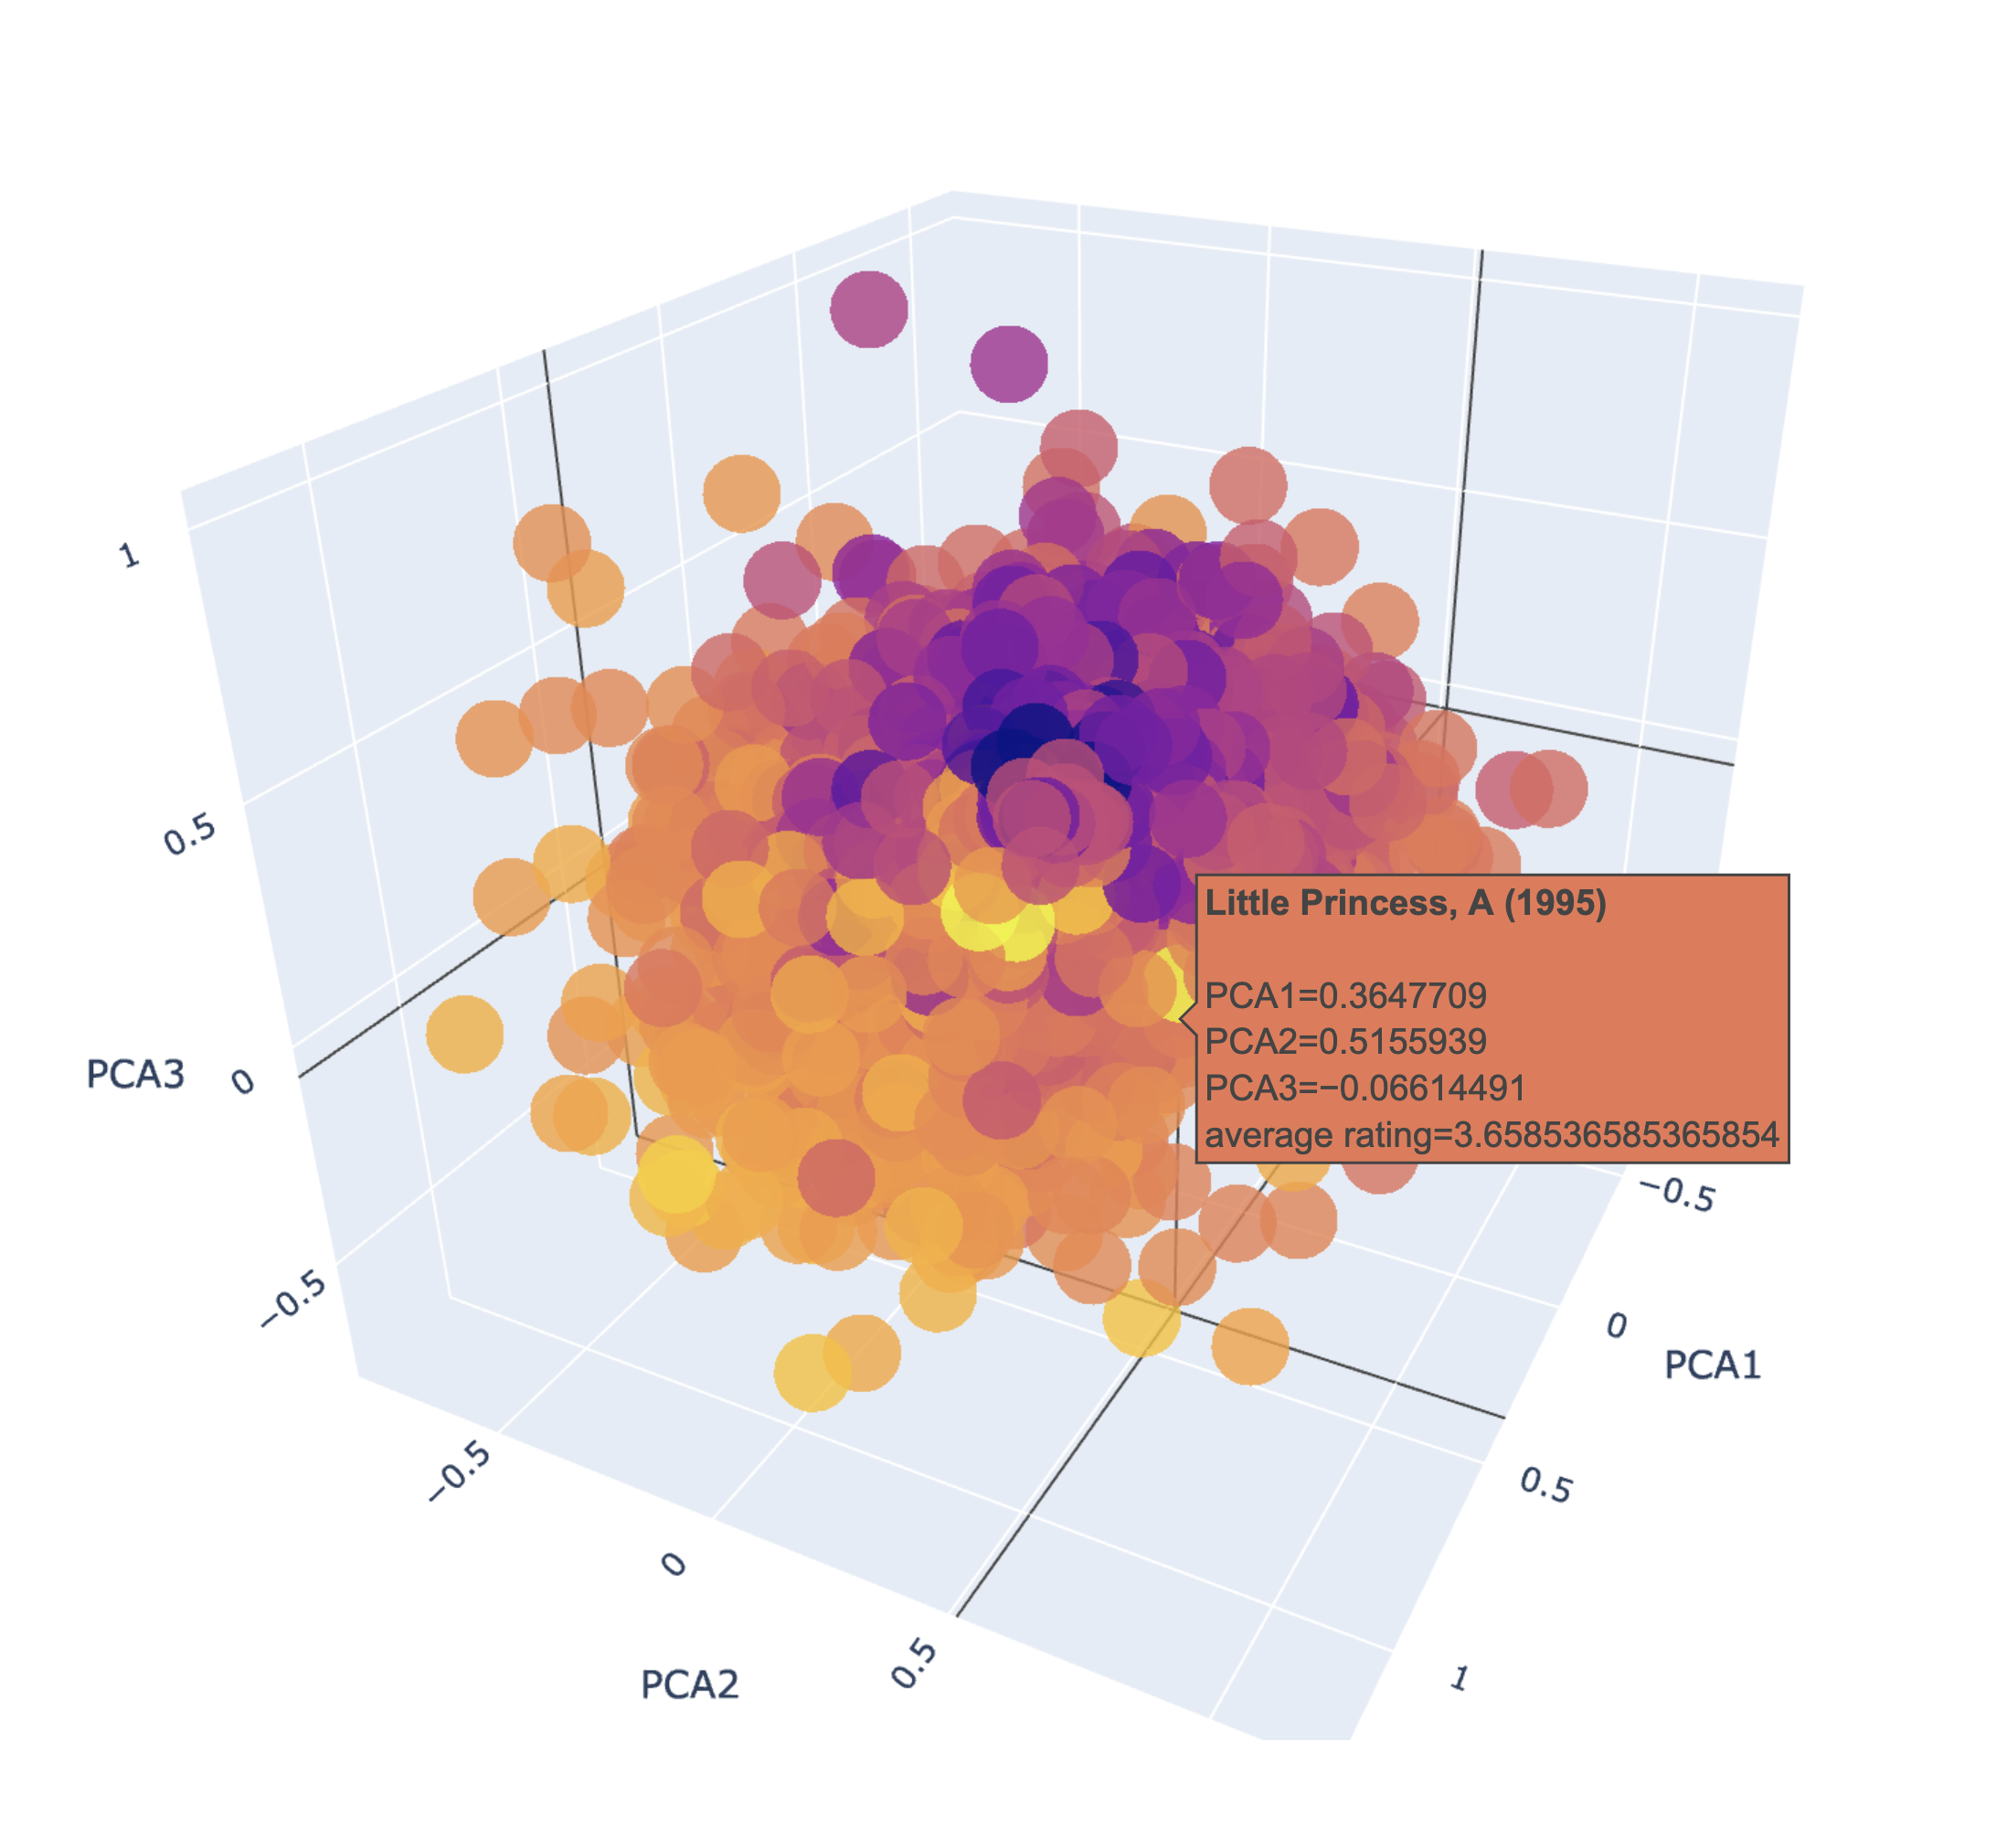

In [ ]:
#| echo: false
Image("../figure/recommender-3d.png", width=800)